# Deep Learning - Exercise 2

This lecture is about introduction to using ANN for regression tasks.

We will use our models on [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset.

This dataset contains fule consumptions of several vehicles in miles per gallon. So, we need to predict the fuel efficiencies of various vehicles from the data that has been provided.

[Open in Google colab](https://colab.research.google.com/github/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_02.ipynb)
[Download from Github](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/dl_02.ipynb)

##### Remember to set **GPU** runtime in Colab!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

tf.version.VERSION

'2.11.0'

In [3]:
"""
Computes MAPE
"""
def mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

"""
Computes SMAPE
"""
def symetric_mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred))/2.0))) * 100

"""
Computes MAE, MSE, MAPE, SMAPE, R2
"""
def compute_metrics(df: pd.DataFrame) -> pd.DataFrame:
    y_true, y_pred = df['y_true'].values, df['y_pred'].values
    return compute_metrics_raw(y_true, y_pred)

def compute_metrics_raw(y_true: pd.Series, y_pred: pd.Series) -> pd.DataFrame:
    mae, mse, mape, smape, r2 = mean_absolute_error(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred), mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), symetric_mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred), r2_score(y_true=y_true, y_pred=y_pred)
    return pd.DataFrame.from_records([{'MAE': mae, 'MSE': mse, 'MAPE': mape, 'SMAPE': smape, 'R2': r2}], index=[0])

In [4]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

In [5]:
def show_history_loss(history):
    plt.figure()
    for key in history.history.keys():
        if 'loss' not in key:
            continue
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()

## 🔎 Let's find answers to these quetions first! 🔎
1) How is regression different from the classification task?
2) How would you solve regression tasks? 
    - Describe briefly the pipeline, model and metrics used
2) How is ANN different from Linear regression model?

# Load the dataset first

## Dataset info
* Number of Instances: 398
* Number of Attributes: 9 including the class attribute

**Attribute Information:**

    1. mpg:           continuous
        * miles per gallon - higher the better
    2. cylinders:     multi-valued discrete
    3. displacement:  continuous
    4. horsepower:    continuous
    5. weight:        continuous
    6. acceleration:  continuous
    7. model year:    multi-valued discrete
    8. origin:        multi-valued discrete
    9. car name:      string (unique for each instance)

* Missing Attribute Values:  horsepower has 6 missing values

In [6]:
url = 'https://raw.githubusercontent.com/rasvob/VSB-FEI-Deep-Learning-Exercises/main/datasets/auto-mpg.csv'
rel_path = 'datasets/auto-mpg.csv'
df = pd.read_csv(url, na_values='?', sep=';')

In [7]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger


## Check missing values

In [8]:
df.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
car_name        0
dtype: int64

## 📊 Plot the data first 
* Which row/columns is the most important for us? Why? 📈
* Can you identify **categorical** features from these plot? How?
* Are the numeric ranges of the features the same? 
    * Can the difference among it make our task harder?
* What about other features? Is there any covariance/colinearity?

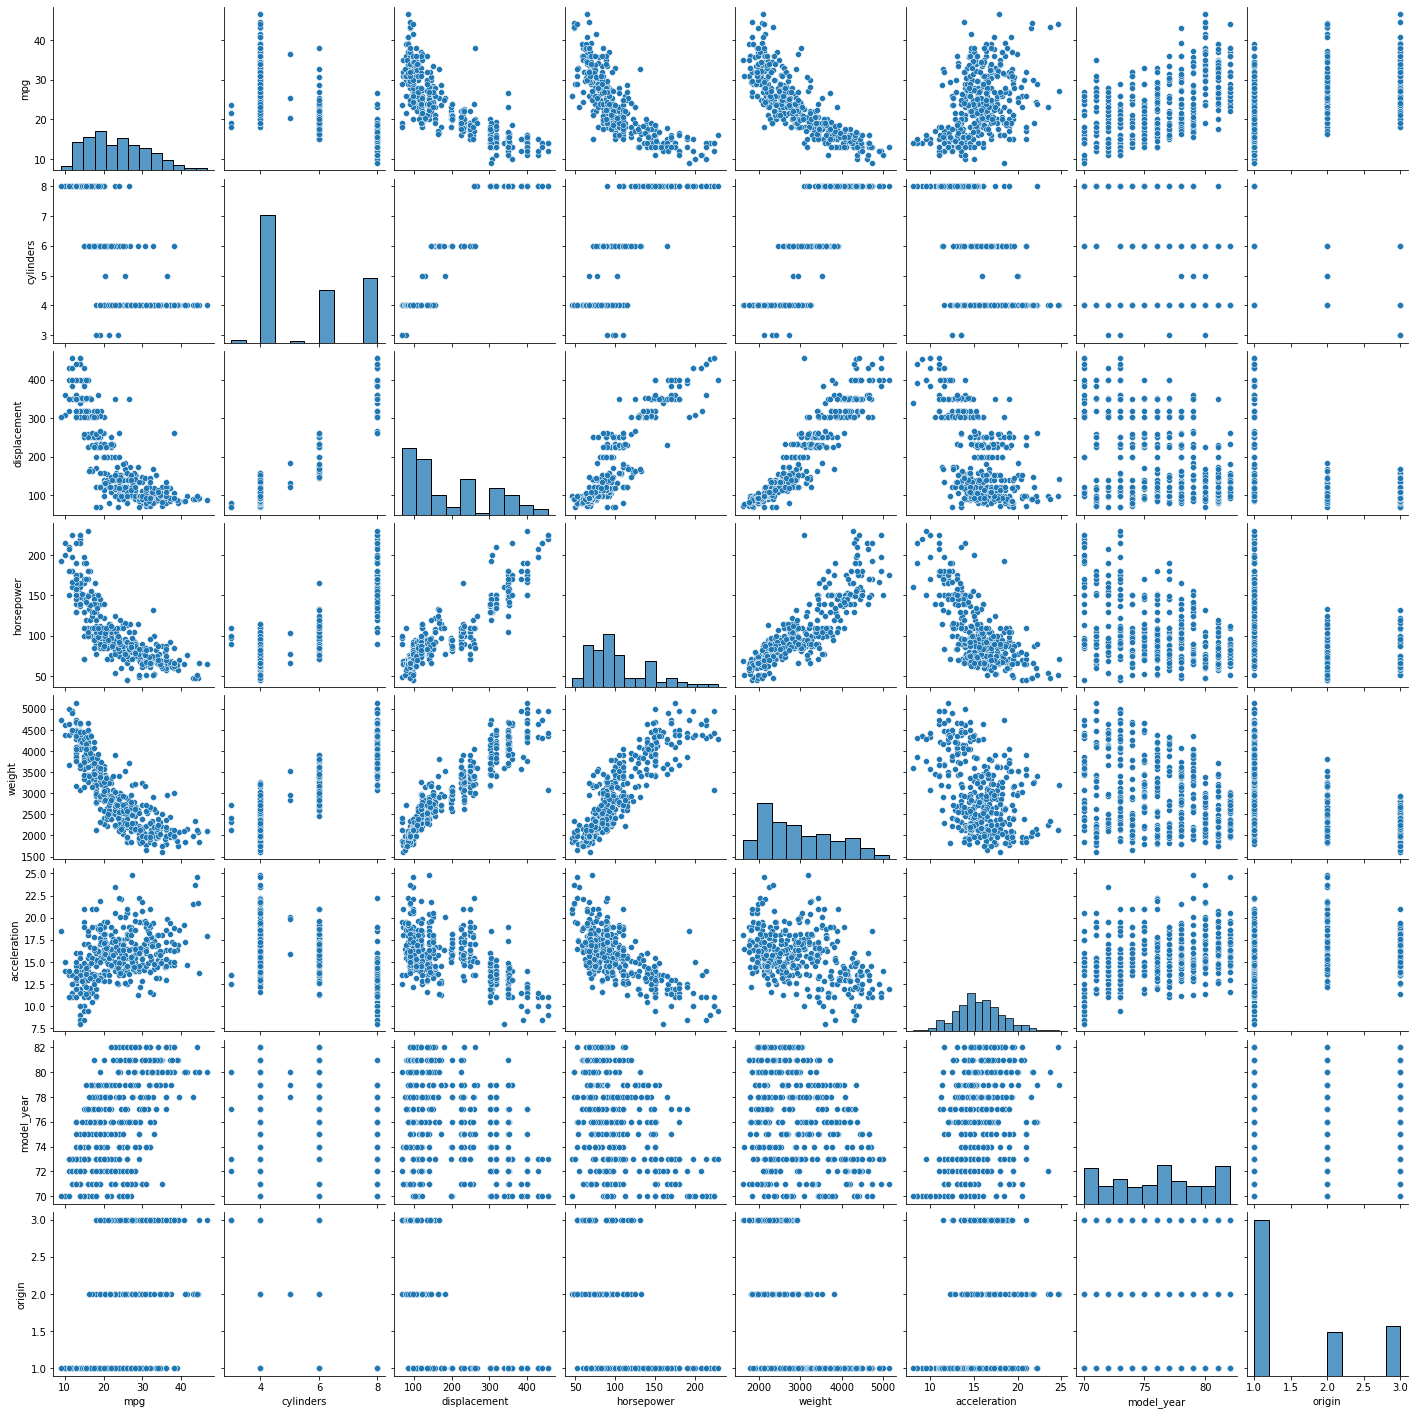

In [9]:
sns.pairplot(df)

## Do you see any colinearity in the data?
* Can it cause any issue? How to deal with it?

<AxesSubplot:>

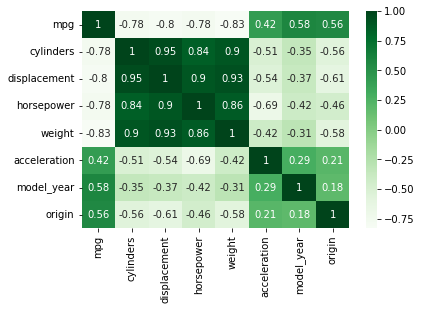

In [10]:
sns.heatmap(df.corr(), cmap='Greens', annot=True)

## We can plot the categorical data using boxplots
* Beware that the data are about cars from 80s, we won't see many 6 or 8 cylinder cars nowadays

<AxesSubplot:xlabel='cylinders', ylabel='mpg'>

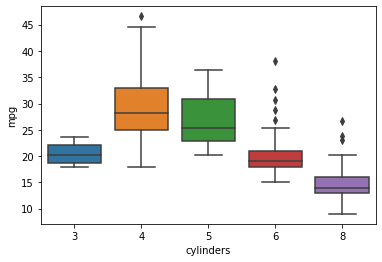

In [11]:
sns.boxplot(data = df, x='cylinders', y='mpg')

<AxesSubplot:xlabel='origin', ylabel='mpg'>

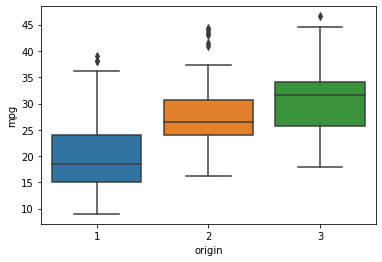

In [12]:
sns.boxplot(data = df, x='origin', y='mpg')

## 💡 There is no info about the *origin* feature = detective work incoming 🙂

### What do you think that the origin means based on the printed data?
* And what car origin is your favourite? 🙂

In [13]:
df.loc[df.origin == 1, 'car_name']

0      chevrolet chevelle malibu
1              buick skylark 320
2             plymouth satellite
3                  amc rebel sst
4                    ford torino
                 ...            
392             chevrolet camaro
393              ford mustang gl
395                dodge rampage
396                  ford ranger
397                   chevy s-10
Name: car_name, Length: 249, dtype: object

In [14]:
df.loc[df.origin == 2, 'car_name']

19     volkswagen 1131 deluxe sedan
20                      peugeot 504
21                      audi 100 ls
22                         saab 99e
23                         bmw 2002
                   ...             
354                     renault 18i
359       peugeot 505s turbo diesel
360                    volvo diesel
375             volkswagen rabbit l
394                       vw pickup
Name: car_name, Length: 70, dtype: object

In [15]:
df.loc[df.origin == 3, 'car_name']

14     toyota corona mark ii
18              datsun pl510
29              datsun pl510
31             toyota corona
53       toyota corolla 1200
               ...          
382           toyota corolla
383              honda civic
384       honda civic (auto)
385            datsun 310 gx
390         toyota celica gt
Name: car_name, Length: 79, dtype: object

## Okay, now we have the basic understanding of the data we can start to try some models
* We need to deal with the NA values first, as is it just a few rows, we will drop the data

In [16]:
df = df.loc[~df.horsepower.isna(), :].copy()

# Finishing touch is the categorical features encoding
* We will need to deal with *origin* and *car_name* features
    * Why is *origin* categorical? Isn't it numerical value already? What's the catch?

### car_name is problematic beacause we have quite a few brands so one-hot encoding would add too many columns
* We will drop the feature

In [17]:
df['car_name'].apply(lambda x: x.split(' ')[0]).value_counts()

ford             48
chevrolet        43
plymouth         31
dodge            28
amc              27
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
mazda            10
oldsmobile       10
fiat              8
peugeot           8
audi              7
vw                6
chrysler          6
volvo             6
opel              4
saab              4
subaru            4
chevy             3
renault           3
maxda             2
cadillac          2
bmw               2
mercedes-benz     2
triumph           1
vokswagen         1
mercedes          1
hi                1
capri             1
chevroelt         1
toyouta           1
nissan            1
Name: car_name, dtype: int64

In [18]:
df = df.drop('car_name', axis=1)

In [19]:
df['origin'] = df['origin'].replace({1: 'USA', 2: 'EUR', 3: 'JAP'})

In [20]:
df = pd.get_dummies(df, columns=['origin'], prefix=['origin_'])

In [21]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin__EUR,origin__JAP,origin__USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


## Split the data into input and output part

In [22]:
X, y = df.drop('mpg', axis=1), df.mpg

In [23]:
X.shape, y.shape

((392, 9), (392,))

## Do the train/test in ratio 80:20

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((313, 9), (79, 9), (313,), (79,))

# Now we can create a baseline model now
* We will use traditional linear regression

## Which model is better explainable from your point of view?
* ANN or Lin. regression? Why?

![Meme01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_meme_reg_01.jpg?raw=true)

## We will use just *horsepower* and *model_year* features because the high correlation values

In [26]:
alg = LinearRegression()
alg.fit(X_train.loc[:, ['horsepower', 'model_year']], y_train)
y_pred = alg.predict(X_test.loc[:, ['horsepower', 'model_year']])

## We can evaluate the model now

* We evaluated quality of classification models using its accuracy in the previous lectures.

* Regression tasks are not different - we have to evaluate model quality as well, but now we use different types of metrics
    * Most basic ones are MAE, RMSE
    * There are many more metrics - R2, MAPE, sMAPE etc
    
### 🔎 Can you define any of the metrics using mathematical formula?

* We have prepared the evaluation functions API for you so you can evaluate all the metrics in one function call

In [27]:
df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

,MAE,MSE,MAPE,SMAPE,R2
0,3.941482,23.74165,19.133313,19.846932,0.581278


# Now we can create our first deep learning model and compare it to the baseline
* The ANN model can use more features as it is designed for bigger datasets and multicolinearity is not so big issue as in the LR case
* We will start with a raw data
* The evaluation step is the same

![Meme02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_meme_reg_04.jpg?raw=true)

## 🔎 Why do we use *linear* activation in the output layer?

# 📒 NOTE for Task 2: This is the benchmark model

In [28]:
inp = keras.layers.Input(shape=(X_train.shape[1]))
                         
hidden_1 = keras.layers.Dense(128, activation='relu')(inp)
hidden_2 = keras.layers.Dense(32, activation='relu')(hidden_1)

out = keras.layers.Dense(1, activation='linear')(hidden_2)

model = keras.Model(inp, out)

model.compile(loss=keras.losses.MeanSquaredError(),  
              optimizer=keras.optimizers.RMSprop(), 
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 128)               1280      
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,441
Trainable params: 5,441
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [29]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(X_train, y_train, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 10ms/step - loss: 2809.5786 - mean_absolute_error: 33.5618 - mean_absolute_percentage_error: 166.9272 - val_loss: 838.4886 - val_mean_absolute_error: 25.6731 - val_mean_absolute_percentage_error: 137.5759
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 2266.2000 - mean_absolute_error: 41.9393 - mean_absolute_percentage_error: 217.5136 - val_loss: 5026.4800 - val_mean_absolute_error: 66.7800 - val_mean_absolute_percentage_error: 343.6978
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 2070.6782 - mean_absolute_error: 37.7983 - mean_absolute_percentage_error: 195.3837 - val_loss: 877.0986 - val_mean_absolute_error: 26.5168 - val_mean_absolute_percentage_error: 141.6046
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 2105.9761 - mean_absolute_error: 34.2820 - mean_absolute_percentage_error: 178.2872 - val_loss: 55.3884 - val_mean_absolute_error: 5.7495 - val_m

## We can compute the same metrics as in the LR model case
* Is the model better?
    * Why?
* Why do we use .ravel() function?

In [30]:
model.load_weights("weights.best.hdf5")

y_pred = model.predict(X_test).ravel()

df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

3/3 [==============================] - 0s 3ms/step


,MAE,MSE,MAPE,SMAPE,R2
0,3.029958,16.399766,13.726028,13.455466,0.710764


## It is very good practice to check the loss function values of train/validation data during the training and not only the metrics
* Do you see any issue with the val_loss?

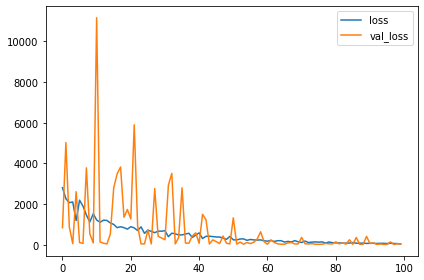

In [31]:
show_history_loss(history)

## The loss function plot show clear instability of learning
* This is a big issue in the regression tasks and it is pretty common one
* It is caused by the features magnitude differences
* We can solve the matter with feature scaling (normalization)
* A https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization layer can be used for solving the matter

### Why is magnitude difference an issue?

* You can see that the gradient of the slope is orders of magnitude larger than the intercept.

![Grad01](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_reg_noscale.png?raw=true)

* If we take a look at the one optimization step values change you can see that only the slope changed in value (we see a vertical line in the plot above, with no change in the intercept parameter). 
    * That’s because the slope gradient is way bigger than the intercept gradient.
    * Gradient actually points in the direction of steepest ascent.
    * Gradient is the vector of all partial derivatives of the loss function with respect to all the model weights.
        * **Basically these values will tell you in which direction (+ or - delta) and how much you should change the individual weights values to lower the loss function value**
        * The amount we adjust our slope each iteration is controlled by a *learning rate* parameter
    
![Grad02](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_reg_noscale_grad.png?raw=true)

### There are a few ways we can solve our problem above. The most common way is to simply scale your features before gradient descent.

![Grad03](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_reg_scale.png?raw=true)

* We can see that not the optimization process is not stuck and computed gradients in the individual steps points in the right direction.

![Grad04](https://github.com/rasvob/VSB-FEI-Deep-Learning-Exercises/blob/main/images/dl_reg_scale_grad.png?raw=true)


* **I recommend visiting https://www.tomasbeuzen.com/deep-learning-with-pytorch/chapters/chapter1_gradient-descent.html for more details about the topic**

# We will normalize the data now and try to fit the model again

In [32]:
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)

## We can take a look at the mean and variance used in the normalization process for each feature

In [33]:
print('Mean: ', np.array(norm_layer.variables[0]))
print('Variance: ', np.array(norm_layer.variables[1]))

Mean:  [5.42172575e+00 1.92186890e+02 1.03297134e+02 2.96547607e+03
 1.56367416e+01 7.61054382e+01 1.78913757e-01 1.91693291e-01
 6.29393041e-01]
Variance:  [2.9147999e+00 1.0745593e+04 1.4390651e+03 7.1411250e+05 7.6496096e+00
 1.3800384e+01 1.4690360e-01 1.5494700e-01 2.3325746e-01]


In [34]:
inp = keras.layers.Input(shape=(X_train.shape[1]))
norm = norm_layer(inp)                  
hidden_1 = keras.layers.Dense(128, activation='relu')(norm)
hidden_2 = keras.layers.Dense(32, activation='relu')(hidden_1)

out = keras.layers.Dense(1, activation='linear')(hidden_2)

model = keras.Model(inp, out)

model.compile(loss=keras.losses.MeanSquaredError(),  
              optimizer=keras.optimizers.RMSprop(), 
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9)]               0         
                                                                 
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 128)               1280      
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,460
Trainable params: 5,441
Non-trainable params: 19
________________________________________________________

## Train the model

In [35]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(X_train, y_train, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 9ms/step - loss: 503.2352 - mean_absolute_error: 21.0334 - mean_absolute_percentage_error: 87.6697 - val_loss: 387.2401 - val_mean_absolute_error: 18.4665 - val_mean_absolute_percentage_error: 76.1758
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 272.2092 - mean_absolute_error: 15.0047 - mean_absolute_percentage_error: 60.9236 - val_loss: 147.3898 - val_mean_absolute_error: 11.0402 - val_mean_absolute_percentage_error: 45.0826
Epoch 3/100
32/32 [==============================] - 0s 4ms/step - loss: 77.0194 - mean_absolute_error: 7.3535 - mean_absolute_percentage_error: 30.8226 - val_loss: 32.0281 - val_mean_absolute_error: 4.4499 - val_mean_absolute_percentage_error: 19.1655
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 23.4155 - mean_absolute_error: 3.8473 - mean_absolute_percentage_error: 17.9881 - val_loss: 16.4461 - val_mean_absolute_error: 3.0609 - val_mean_absolute_percen

In [36]:
model.load_weights("weights.best.hdf5")

y_pred = model.predict(X_test).ravel()

df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

3/3 [==============================] - 0s 4ms/step


,MAE,MSE,MAPE,SMAPE,R2
0,2.284548,9.94551,10.378015,10.165806,0.824595


## Do you see any difference?

* Normalization can help training of our neural networks as the different features are on a similar scale, which helps to stabilize the gradient descent step, allowing us to use larger learning rates or help models converge faster for a given learning rate.

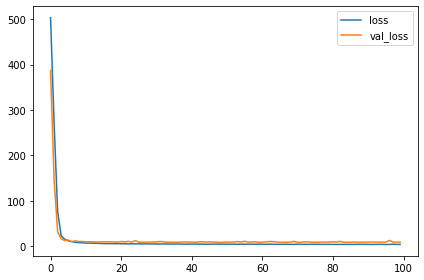

In [37]:
show_history_loss(history)

## We can transform the output as well
* There are multiple scaling options
    * MinMax, Std. scale, Log, BoxCox, ...
    
### We will test *MinMaxScaler* into (-1;1) range

In [38]:
scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape((-1, 1))).ravel()
y_test_scaled = scaler.transform(np.array(y_test).reshape((-1, 1))).ravel()

In [39]:
y_train_scaled[:10]

array([ 0.32978723, -0.04255319, -0.09574468, -0.44680851, -0.73404255,
       -0.12234043, -0.68085106, -0.30851064, -0.36170213, -0.38829787])

# ⚠ Beware the output layer range of the used activation function ⚠
### If there is a mismatch between range of the output activation function and output variable range, the model won't work as ANN may not be able to produce numbers from the correct range

### We will try to produce such an issue now
* We will set *sigmoid* as an output func. thus we won't be able to output negative numbers

# ☣ ANTI-EXAMPLE ☣

In [40]:
inp = keras.layers.Input(shape=(X_train.shape[1]))
norm = norm_layer(inp)                  
hidden_1 = keras.layers.Dense(128, activation='relu')(norm)
hidden_2 = keras.layers.Dense(32, activation='relu')(hidden_1)

out = keras.layers.Dense(1, activation='sigmoid')(hidden_2)

model = keras.Model(inp, out)

model.compile(loss=keras.losses.MeanSquaredError(),  
              optimizer=keras.optimizers.RMSprop(), 
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9)]               0         
                                                                 
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_6 (Dense)             (None, 128)               1280      
                                                                 
 dense_7 (Dense)             (None, 32)                4128      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,460
Trainable params: 5,441
Non-trainable params: 19
________________________________________________________

## Train the model

In [41]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(X_train, y_train_scaled, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 9ms/step - loss: 0.4062 - mean_absolute_error: 0.5502 - mean_absolute_percentage_error: 304.7802 - val_loss: 0.2458 - val_mean_absolute_error: 0.4261 - val_mean_absolute_percentage_error: 171.7134
Epoch 2/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2427 - mean_absolute_error: 0.4186 - mean_absolute_percentage_error: 172.5131 - val_loss: 0.2059 - val_mean_absolute_error: 0.3823 - val_mean_absolute_percentage_error: 128.5703
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2199 - mean_absolute_error: 0.3902 - mean_absolute_percentage_error: 135.3225 - val_loss: 0.1930 - val_mean_absolute_error: 0.3661 - val_mean_absolute_percentage_error: 123.4514
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.2083 - mean_absolute_error: 0.3727 - mean_absolute_percentage_error: 128.1169 - val_loss: 0.1877 - val_mean_absolute_error: 0.3590 - val_mean_absolute_percentage_erro

In [42]:
model.load_weights("weights.best.hdf5")

y_pred = model.predict(X_test).ravel()

df_pred = pd.DataFrame({'y_true': y_test_scaled, 'y_pred': y_pred})
compute_metrics(df_pred)

3/3 [==============================] - 0s 3ms/step


,MAE,MSE,MAPE,SMAPE,R2
0,0.393899,0.218592,90.258554,169.709433,-0.362589


## Now we can transfer the data back

In [43]:
y_pred = scaler.inverse_transform(y_pred.reshape((-1, 1))).ravel()
y_pred[:10]

array([27.8     , 27.800009, 27.8     , 27.8     , 27.828058, 27.842356,
       27.933199, 32.416428, 27.8     , 31.09636 ], dtype=float32)

In [44]:
df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

,MAE,MSE,MAPE,SMAPE,R2
0,7.405291,77.259139,43.549838,32.319156,-0.362589


# Plot of the y_test vs. y_pred
* Do you see the issue?
* How should the ideal plot look like?

<AxesSubplot:xlabel='mpg'>

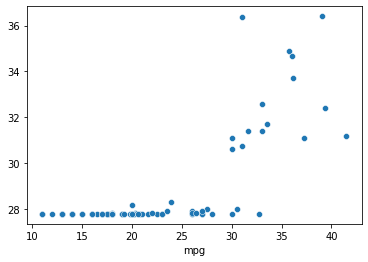

In [45]:
sns.scatterplot(x=y_test, y=y_pred)

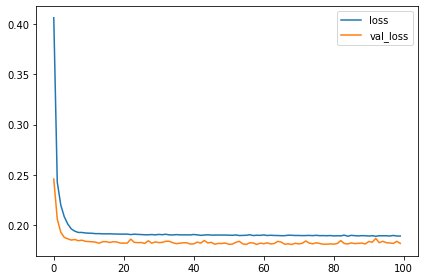

In [46]:
show_history_loss(history)

# ✅ Now we will try to fix the issue and replace sigmoid function with the correct one ✅
* What function can we use? Why?

In [47]:
inp = keras.layers.Input(shape=(X_train.shape[1]))
norm = norm_layer(inp)                  
hidden_1 = keras.layers.Dense(128, activation='relu')(norm)
hidden_2 = keras.layers.Dense(32, activation='relu')(hidden_1)

out = keras.layers.Dense(1, activation='tanh')(hidden_2)

model = keras.Model(inp, out)

model.compile(loss=keras.losses.MeanSquaredError(),  
              optimizer=keras.optimizers.RMSprop(), 
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 9)]               0         
                                                                 
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_9 (Dense)             (None, 128)               1280      
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,460
Trainable params: 5,441
Non-trainable params: 19
________________________________________________________

## Train the model

In [48]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(X_train, y_train_scaled, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

Epoch 1/100
32/32 [==============================] - 1s 9ms/step - loss: 0.0744 - mean_absolute_error: 0.1844 - mean_absolute_percentage_error: 97.3640 - val_loss: 0.0435 - val_mean_absolute_error: 0.1534 - val_mean_absolute_percentage_error: 106.1955
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0239 - mean_absolute_error: 0.1134 - mean_absolute_percentage_error: 94.8168 - val_loss: 0.0309 - val_mean_absolute_error: 0.1391 - val_mean_absolute_percentage_error: 92.1699
Epoch 3/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0202 - mean_absolute_error: 0.1058 - mean_absolute_percentage_error: 86.4407 - val_loss: 0.0278 - val_mean_absolute_error: 0.1313 - val_mean_absolute_percentage_error: 100.0369
Epoch 4/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0179 - mean_absolute_error: 0.0981 - mean_absolute_percentage_error: 79.6206 - val_loss: 0.0333 - val_mean_absolute_error: 0.1438 - val_mean_absolute_percentage_error: 10

In [49]:
model.load_weights("weights.best.hdf5")

y_pred = model.predict(X_test).ravel()

df_pred = pd.DataFrame({'y_true': y_test_scaled, 'y_pred': y_pred})
compute_metrics(df_pred)

3/3 [==============================] - 0s 4ms/step


,MAE,MSE,MAPE,SMAPE,R2
0,0.126777,0.029499,64.31619,47.312126,0.816116


## Now we can transfer the data back

In [50]:
y_pred = scaler.inverse_transform(y_pred.reshape((-1, 1))).ravel()
y_pred[:10]

array([19.888056, 20.240963, 13.489772, 11.916823, 23.971987, 24.218538,
       26.364285, 33.18836 , 17.757029, 30.392305], dtype=float32)

In [51]:
df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

,MAE,MSE,MAPE,SMAPE,R2
0,2.38341,10.426296,10.881085,10.707968,0.816116


# Plot of the y_test vs. y_pred
* Is it better?

<AxesSubplot:xlabel='mpg'>

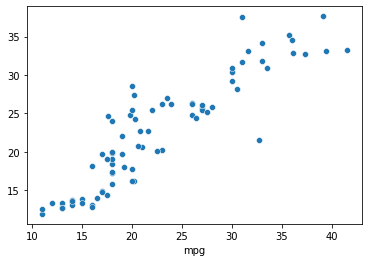

In [52]:
sns.scatterplot(x=y_test, y=y_pred)

## The convergence was quite fast
* We can see that there is an issue with the val_loss stability as the changes are very low now

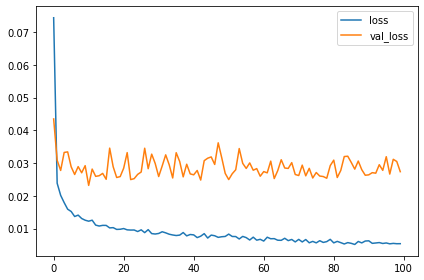

In [53]:
show_history_loss(history)

## Tasks for the lecture (2p)

1) Try to use [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) for the output values in a similar manner as the MinMaxScaler - **(1p)**
    - When do we use it? Why?
    - If you wanted to guess if it helps, what do you think? 
        * Plot histogram of the output (*mpg*), you can make an educated guess based on it 🙂
    
2) Try to design your own network and beat the **benchmark** network used in the lecture - **(1p)**

In [57]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape((-1, 1))).ravel()
y_test_scaled = scaler.transform(np.array(y_test).reshape((-1, 1))).ravel()

model.compile(loss=keras.losses.MeanSquaredError(),  
              optimizer=keras.optimizers.RMSprop(), 
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(X_train, y_train_scaled, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

model.load_weights("weights.best.hdf5")

y_pred = model.predict(X_test).ravel()
y_pred = scaler.inverse_transform(y_pred.reshape((-1, 1))).ravel()

df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

32/32 [==============================] - 0s 3ms/step - loss: 0.1163 - mean_absolute_error: 0.2173 - mean_absolute_percentage_error: 29.2428 - val_loss: 0.1567 - val_mean_absolute_error: 0.3057 - val_mean_absolute_percentage_error: 151.8236
Epoch 95/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1161 - mean_absolute_error: 0.2145 - mean_absolute_percentage_error: 26.7647 - val_loss: 0.1453 - val_mean_absolute_error: 0.2864 - val_mean_absolute_percentage_error: 130.6959
Epoch 96/100
32/32 [==============================] - 0s 3ms/step - loss: 0.1169 - mean_absolute_error: 0.2152 - mean_absolute_percentage_error: 26.1245 - val_loss: 0.1528 - val_mean_absolute_error: 0.3032 - val_mean_absolute_percentage_error: 143.3974
Epoch 97/100
32/32 [==============================] - 0s 4ms/step - loss: 0.1159 - mean_absolute_error: 0.2165 - mean_absolute_percentage_error: 27.0713 - val_loss: 0.1533 - val_mean_absolute_error: 0.2951 - val_mean_absolute_percentage_error: 139.4418
E

3/3 [==============================] - 0s 4ms/step


,MAE,MSE,MAPE,SMAPE,R2
0,2.73236,14.853192,12.897867,12.182436,0.73804


In [58]:

scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape((-1, 1))).ravel()
y_test_scaled = scaler.transform(np.array(y_test).reshape((-1, 1))).ravel()

inp = keras.layers.Input(shape=(X_train.shape[1]))
norm = norm_layer(inp)                  
hidden_1 = keras.layers.Dense(64, activation='relu')(norm)
dropout_1 = keras.layers.Dropout(0.2)(hidden_1)
hidden_2 = keras.layers.Dense(64, activation='relu')(dropout_1)
dropout_2 = keras.layers.Dropout(0.2)(hidden_2)

out = keras.layers.Dense(1, activation='tanh')(dropout_2)

model = keras.Model(inp, out)

model.compile(loss=keras.losses.MeanSquaredError(),  
              optimizer=keras.optimizers.RMSprop(), 
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(X_train, y_train_scaled, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

model.load_weights("weights.best.hdf5")

y_pred = model.predict(X_test).ravel()
y_pred = scaler.inverse_transform(y_pred.reshape((-1, 1))).ravel()

df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

32/32 [==============================] - 0s 4ms/step - loss: 0.0126 - mean_absolute_error: 0.0837 - mean_absolute_percentage_error: 68.2650 - val_loss: 0.0238 - val_mean_absolute_error: 0.1159 - val_mean_absolute_percentage_error: 79.9378
Epoch 95/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0146 - mean_absolute_error: 0.0864 - mean_absolute_percentage_error: 71.1589 - val_loss: 0.0240 - val_mean_absolute_error: 0.1147 - val_mean_absolute_percentage_error: 81.4264
Epoch 96/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0128 - mean_absolute_error: 0.0869 - mean_absolute_percentage_error: 72.8708 - val_loss: 0.0244 - val_mean_absolute_error: 0.1165 - val_mean_absolute_percentage_error: 77.6397
Epoch 97/100
32/32 [==============================] - 0s 4ms/step - loss: 0.0153 - mean_absolute_error: 0.0899 - mean_absolute_percentage_error: 79.4854 - val_loss: 0.0249 - val_mean_absolute_error: 0.1159 - val_mean_absolute_percentage_error: 78.2753
Epoch

,MAE,MSE,MAPE,SMAPE,R2
0,2.365347,10.216777,10.636471,10.372136,0.819811


In [54]:

scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape((-1, 1))).ravel()
y_test_scaled = scaler.transform(np.array(y_test).reshape((-1, 1))).ravel()

inp = keras.layers.Input(shape=(X_train.shape[1]))
norm = norm_layer(inp)                  
hidden_1 = keras.layers.Dense(96, activation='relu')(norm)
dropout_1 = keras.layers.Dropout(0.2)(hidden_1)

out = keras.layers.Dense(1, activation='tanh')(dropout_1)

model = keras.Model(inp, out)

model.compile(loss=keras.losses.MeanSquaredError(),  
              optimizer=keras.optimizers.RMSprop(), 
              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights.best.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

history = model.fit(X_train, y_train_scaled, validation_split=0.2, callbacks=[model_checkpoint_callback], batch_size=8, epochs=100)

model.load_weights("weights.best.hdf5")

y_pred = model.predict(X_test).ravel()
y_pred = scaler.inverse_transform(y_pred.reshape((-1, 1))).ravel()

df_pred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
compute_metrics(df_pred)

32/32 [==============================] - 0s 4ms/step - loss: 0.0135 - mean_absolute_error: 0.0861 - mean_absolute_percentage_error: 77.9733 - val_loss: 0.0243 - val_mean_absolute_error: 0.1179 - val_mean_absolute_percentage_error: 96.2701
Epoch 98/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0128 - mean_absolute_error: 0.0837 - mean_absolute_percentage_error: 70.5120 - val_loss: 0.0262 - val_mean_absolute_error: 0.1254 - val_mean_absolute_percentage_error: 104.9256
Epoch 99/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0121 - mean_absolute_error: 0.0821 - mean_absolute_percentage_error: 68.1244 - val_loss: 0.0240 - val_mean_absolute_error: 0.1178 - val_mean_absolute_percentage_error: 98.1859
Epoch 100/100
32/32 [==============================] - 0s 3ms/step - loss: 0.0128 - mean_absolute_error: 0.0840 - mean_absolute_percentage_error: 73.0600 - val_loss: 0.0247 - val_mean_absolute_error: 0.1200 - val_mean_absolute_percentage_error: 98.6254


3/3 [==============================] - 0s 4ms/step


,MAE,MSE,MAPE,SMAPE,R2
0,2.354828,10.434246,10.642238,10.400498,0.815975
